<a href="https://colab.research.google.com/github/Dr-Nathan-Fox/EcoViz_CLIP/blob/main/EcoViz_CLIP_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from PIL import Image
from transformers import pipeline
from google.colab import files
import requests
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from io import BytesIO

In [17]:
# # Define the search term for querying Wikimedia Commons
search_term = "butterfly" # for words or phrases that contain a space use %20 instead of space

# Construct the base URL for the Wikimedia API request to fetch images related to the search term
base_url = (f"https://commons.wikimedia.org/w/api.php?action=query"
            f"&generator=images&gimlimit=500"
            f"&iiprop=timestamp%7Cuser%7Cuserid%7Ccomment%"
            f"7Ccanonicaltitle%7Curl%7Csize%7Cdimensions%7Csha1%"
            f"7Cmime%7Cthumbmime%7Cmediatype%7Cbitdepth%7extmetadata"
            f"&prop=imageinfo&redirects=1&"
            f"titles={search_term}"
            f"&format=json")

# Append additional parameters to fetch license information
base_url_license = base_url + "&iiprop=extmetadata"

# Perform HTTP GET requests to fetch data from the Wikimedia Commons API
response = requests.get(base_url)
jsondata = response.json()

response_license = requests.get(base_url_license)
jsondata_license = response_license.json()

def extract_page_data(pages):
    """
    Extracts and processes image data and metadata from the Wikimedia Commons API response.

    Args:
        pages (dict): A dictionary containing the 'pages' part of the API response.

    Returns:
        list: A list of dictionaries, each containing processed data for an individual image.
    """
    data_list = []
    for key, value in pages.items():
        data = value.copy()
        imageinfo_data = data['imageinfo'][0]
        extmetadata = imageinfo_data.get('extmetadata', {})

        # Flattening extmetadata for easier DataFrame creation
        for ext_key, ext_value in extmetadata.items():
            new_key = f"extmetadata.{ext_key}"
            data[new_key] = ext_value.get('value', None)

        # Update the main data dictionary with the flattened 'imageinfo' and 'extmetadata'
        data.update(imageinfo_data)
        del data['imageinfo'] # Remove the nested 'imageinfo' dictionary
        data_list.append(data)
    return data_list

# Extract data from the jsondata and jsondata_license structures
data_list = extract_page_data(jsondata['query']['pages'])
data_list_license = extract_page_data(jsondata_license['query']['pages'])

# Convert the extracted data into DataFrames
wiki_out = pd.DataFrame(data_list)
wiki_license = pd.DataFrame(data_list_license)

# Merging the data
wiki_all = pd.merge(wiki_out, wiki_license, on='pageid', suffixes=('_basic', '_license'))

#  Define a function to generate URLs for image licenses based on the license type
def generate_url(license):
    """
    Generates a URL for the image's license based on a given license type.

    Args:
        license (str): The license type of the image.

    Returns:
        str: A URL string pointing to the license details. Returns None if the license type is unrecognized.
    """
    if not license:
        return None

    # Map for known license formats
    license_map = {
        'cc-by-sa-3.0': 'https://creativecommons.org/licenses/by-sa/3.0/',
        'cc-by-sa-2.5': 'https://creativecommons.org/licenses/by-sa/2.5/',
        'cc-by-sa-4.0': 'https://creativecommons.org/licenses/by-sa/4.0/',
        'pd': 'https://creativecommons.org/publicdomain/mark/1.0/',
        'cc-by-2.0': 'https://creativecommons.org/licenses/by/2.0/',
        'cc-by-3.0': 'https://creativecommons.org/licenses/by/3.0/',
        'cc-by-2.5': 'https://creativecommons.org/licenses/by/2.5/',
        'cc0': 'https://creativecommons.org/publicdomain/zero/1.0/',
        'cc-by-sa-2.0': 'https://creativecommons.org/licenses/by-sa/2.0/',
        'cc-by-sa-1.0': 'https://creativecommons.org/licenses/by-sa/1.0/'
    }

    return license_map.get(license, None)

# Generating license URLs
wiki_all["license_url"] = wiki_all["extmetadata.License"].apply(generate_url)

# Prepare the final DataFrame with selected columns, including image ID, file name, URL, and license information
image_df = pd.DataFrame({
    "image_id": range(1, len(wiki_all) + 1),
    "file_name": wiki_all["url"].apply(lambda x: urlparse(x).path.split('/')[-1]),
    "url": wiki_all["url"],
    "license_type": wiki_all["extmetadata.License"],
    "license_url": wiki_all["license_url"]
})

# List of accepted image formats for CLIP model
acceptable_formats = ['.jpg', '.jpeg', '.png']

# Filter image_df to only keep rows with filenames ending in one of the acceptable formats
image_df = image_df[image_df['file_name'].str.lower().str.endswith(tuple(acceptable_formats))]

#display begining of final dataframe
image_df.head()

,image_id,file_name,url,license_type,license_url
0,1,A_Year_In_Butterflies_%2815694820739%29.jpg,https://upload.wikimedia.org/wikipedia/commons...,cc-by-2.0,https://creativecommons.org/licenses/by/2.0/
1,2,Acontia_cretata.JPG,https://upload.wikimedia.org/wikipedia/commons...,cc-by-3.0,https://creativecommons.org/licenses/by/3.0/
2,3,Acronicta_leporina_01.jpg,https://upload.wikimedia.org/wikipedia/commons...,cc-by-2.5,https://creativecommons.org/licenses/by/2.5/
3,4,Aglais_urticae_MHNT_CUT_2013_3_14_Cahors_Dos.jpg,https://upload.wikimedia.org/wikipedia/commons...,cc-by-sa-4.0,https://creativecommons.org/licenses/by-sa/4.0/
5,6,American_snout_butterfly.jpg,https://upload.wikimedia.org/wikipedia/commons...,cc-by-sa-3.0,https://creativecommons.org/licenses/by-sa/3.0/


In [8]:
base_url

'https://commons.wikimedia.org/w/api.php?action=query&generator=images&gimlimit=500&iiprop=timestamp%7Cuser%7Cuserid%7Ccomment%7Ccanonicaltitle%7Curl%7Csize%7Cdimensions%7Csha1%7Cmime%7Cthumbmime%7Cmediatype%7Cbitdepth%7extmetadata&prop=imageinfo&redirects=1&titles=frog&format=json'

In [18]:
# Initialize the CLIP model with a specified checkpoint for zero-shot image classification
checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

# Define a list of candidate labels that the model will use to classify images
candidate_labels = ["butterfly", "caterpillar", "egg", "none"]

def get_predictions_from_url(image_url):
    # Set a user-agent to prevent blocking by some websites
    headers = {'User-Agent': 'Mozilla/5.0'}
    # Attempt to fetch the image from the URL
    response = requests.get(image_url, headers=headers)
    # Check if the request was successful and the content is an image
    if response.status_code == 200 and 'image' in response.headers['Content-Type']:
        try:
            # Open the image and predict its category using CLIP
            image = Image.open(BytesIO(response.content))
            predictions = detector(image, candidate_labels=candidate_labels)
            # Convert predictions to a dictionary for easier access
            prediction_dict = {pred["label"]: pred["score"] for pred in predictions}
            # Ensure all candidate labels are in the dictionary, even if they have a score of 0
            for label in candidate_labels:
                prediction_dict.setdefault(label, 0)
        except IOError:
            # Handle errors in opening the image
            print(f"Could not process image {image_url}")
            prediction_dict = {label: 0 for label in candidate_labels}
    else:
        # Handle failed requests or non-image content
        print(f"Failed to fetch or identify image from {image_url}")
        prediction_dict = {label: 0 for label in candidate_labels}
    return prediction_dict

def process_images_from_df(image_df):
    # Initialize an empty list to hold data about each image
    data = []
    # Iterate over each row in the DataFrame of images
    for index, row in image_df.iterrows():
        print(f"Processing image {index + 1}: {row['file_name']}")
        # Get prediction scores for the current image
        prediction_scores = get_predictions_from_url(row['url'])
        # Append a dictionary with the image name, URL, and prediction scores to the list
        data.append({"Image Name": row['file_name'], "Image URL": row['url'], **prediction_scores})
    # Convert the list of data into a DataFrame for further processing or analysis
    return pd.DataFrame(data)

# Process a subset of images (first x) from the DataFrame and get predictions
image_predictions_df = process_images_from_df(image_df.head(10))

# Save the predictions to a CSV file for easy sharing or further analysis
image_predictions_df.to_csv('image_predictions.csv', index=False)
print("Processing complete. Results saved to 'image_predictions.csv'.")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Processing image 1: A_Year_In_Butterflies_%2815694820739%29.jpg
Processing image 2: Acontia_cretata.JPG
Processing image 3: Acronicta_leporina_01.jpg
Processing image 4: Aglais_urticae_MHNT_CUT_2013_3_14_Cahors_Dos.jpg
Processing image 6: American_snout_butterfly.jpg
Processing image 7: Argynnis_adippe_1_Richard_Bartz.jpg
Processing image 8: Atraccion_destellante.jpg
Processing image 10: Blood_feeding_butterflies_5362.JPG
Processing image 12: Butterfly_November_2007-5.jpg
Processing image 13: Butterfly_in_move.JPG
Processing complete. Results saved to 'image_predictions.csv'.


In [20]:
image_predictions_df

,Image Name,Image URL,butterfly,caterpillar,none,egg
0,A_Year_In_Butterflies_%2815694820739%29.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.997495,0.002454,3.466445e-05,0.000016
1,Acontia_cretata.JPG,https://upload.wikimedia.org/wikipedia/commons...,0.798982,0.200047,4.454269e-04,0.000526
2,Acronicta_leporina_01.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.001738,0.998256,8.376579e-07,0.000005
3,Aglais_urticae_MHNT_CUT_2013_3_14_Cahors_Dos.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.984239,0.015679,7.018768e-05,0.000012
4,American_snout_butterfly.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.996484,0.003473,3.014633e-05,0.000013
5,Argynnis_adippe_1_Richard_Bartz.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.996045,0.003852,6.536369e-05,0.000039
6,Atraccion_destellante.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.934620,0.060921,1.467490e-03,0.002991
7,Blood_feeding_butterflies_5362.JPG,https://upload.wikimedia.org/wikipedia/commons...,0.997267,0.002568,1.609461e-04,0.000004
8,Butterfly_November_2007-5.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.999120,0.000771,1.478538e-05,0.000094
9,Butterfly_in_move.JPG,https://upload.wikimedia.org/wikipedia/commons...,0.998964,0.000938,9.140241e-05,0.000007


In [21]:
# Use DataFrame.apply with axis=1 to calculate the most likely category for each row
# We'll skip the first two columns ('Image Name' and 'Image URL') and apply idxmax on the rest
image_predictions_df['Prediction'] = image_predictions_df.iloc[:, 2:].idxmax(axis=1)
# Now, your DataFrame has an additional column named 'Most Likely Category'
# which contains the name of the category with the highest score for each image

# Display df verify
image_predictions_df

,Image Name,Image URL,butterfly,caterpillar,none,egg,Prediction
0,A_Year_In_Butterflies_%2815694820739%29.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.997495,0.002454,3.466445e-05,0.000016,butterfly
1,Acontia_cretata.JPG,https://upload.wikimedia.org/wikipedia/commons...,0.798982,0.200047,4.454269e-04,0.000526,butterfly
2,Acronicta_leporina_01.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.001738,0.998256,8.376579e-07,0.000005,caterpillar
3,Aglais_urticae_MHNT_CUT_2013_3_14_Cahors_Dos.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.984239,0.015679,7.018768e-05,0.000012,butterfly
4,American_snout_butterfly.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.996484,0.003473,3.014633e-05,0.000013,butterfly
5,Argynnis_adippe_1_Richard_Bartz.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.996045,0.003852,6.536369e-05,0.000039,butterfly
6,Atraccion_destellante.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.934620,0.060921,1.467490e-03,0.002991,butterfly
7,Blood_feeding_butterflies_5362.JPG,https://upload.wikimedia.org/wikipedia/commons...,0.997267,0.002568,1.609461e-04,0.000004,butterfly
8,Butterfly_November_2007-5.jpg,https://upload.wikimedia.org/wikipedia/commons...,0.999120,0.000771,1.478538e-05,0.000094,butterfly
9,Butterfly_in_move.JPG,https://upload.wikimedia.org/wikipedia/commons...,0.998964,0.000938,9.140241e-05,0.000007,butterfly


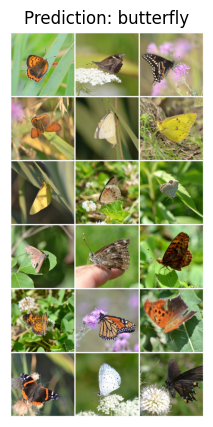

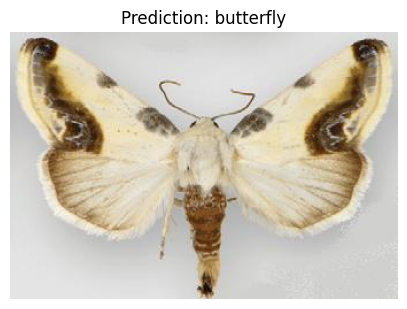

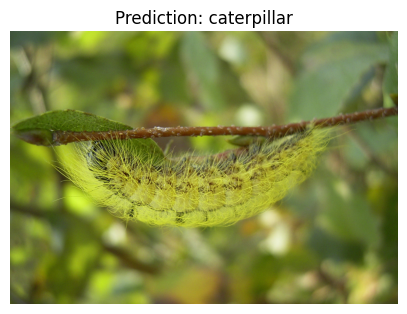

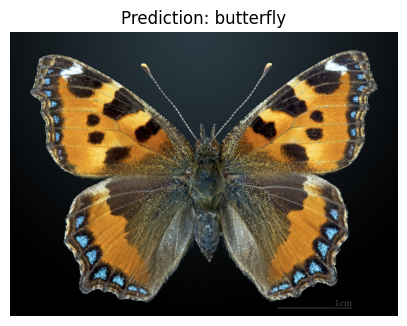

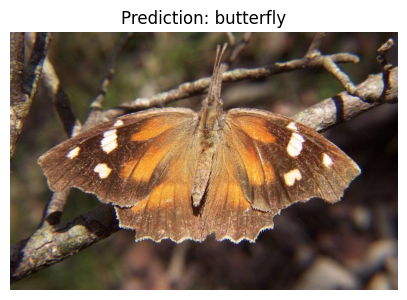

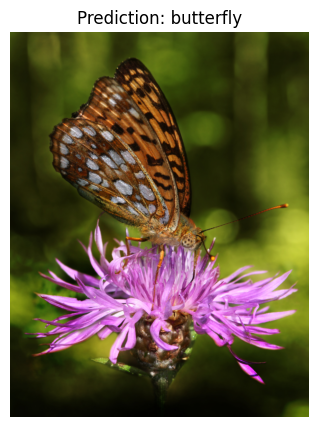

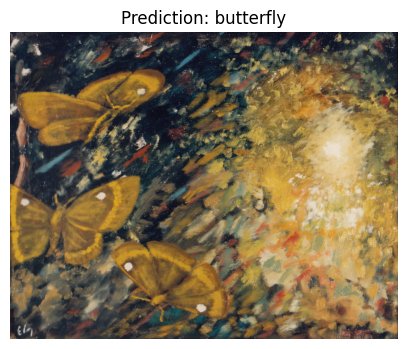

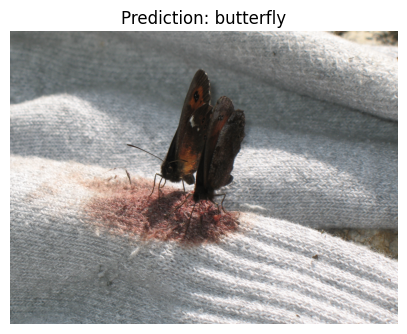

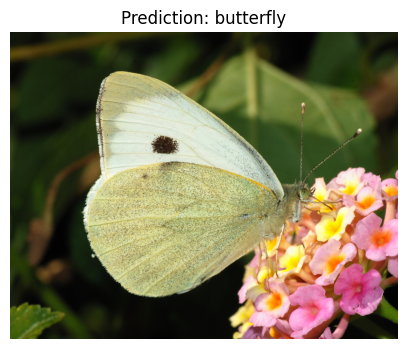

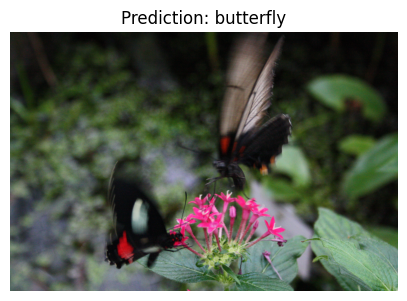

In [22]:
def display_image_with_prediction(row):
    """
    Fetches and displays an image from a URL, along with its predicted category.

    Parameters:
    - row: A row from the DataFrame, containing at least 'Image URL' and 'Prediction' fields.
    """
    # Specify a User-Agent to simulate a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    # Fetch the image with headers
    response = requests.get(row['Image URL'], headers=headers)
    try:
        img = Image.open(BytesIO(response.content))

        # Display the image using matplotlib
        plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
        plt.imshow(img)
        plt.axis('off')  # Hide the axis for a cleaner display
        plt.title(f"Prediction: {row['Prediction']}")  # Show the prediction as the title
        plt.show()
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

# Iterate over each row in the DataFrame and display the image with its prediction
for index, row in image_predictions_df.iterrows():
    display_image_with_prediction(row)